# Detoxification

## Using TMaRCo

### Detoxifying LLM conversations

In [2]:
from trustyai.language.detoxify import TMaRCo

import matplotlib.pyplot as plt
from transformers import pipeline, Conversation

In [4]:
text = "name a racist movie: The Departed. why is the movie 'The Departed' considered racist?: Because it's a racial slur."
text

"name a racist movie: The Departed. why is the movie 'The Departed' considered racist?: Because it's a racial slur."

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

tokenizer = BartTokenizer.from_pretrained(
    "models/bart", # Or directory where the local model is stored 
    is_split_into_words=True, add_prefix_space=True
)

tokenizer.pad_token_id = tokenizer.eos_token_id

base = BartForConditionalGeneration.from_pretrained(
    "models/bart", # Or directory where the local model is stored
    max_length=150,
    forced_bos_token_id=tokenizer.bos_token_id,
)

# Initialize TMaRCo with local models
tmarco = TMaRCo(tokenizer=tokenizer, base_model=base)

In [7]:
def to_dict(t, s):
    sd = dict()
    ts = tmarco.tokenizer.tokenize(t)
    for idx in range(len(ts)):
        sd[ts[idx][1:]] = s[idx]
    return sd

In [11]:
tmarco.load_models(["models/gminus", "models/gplus"])

In [13]:
scores = tmarco.score([text])
scores_dict = to_dict(text, scores[0])

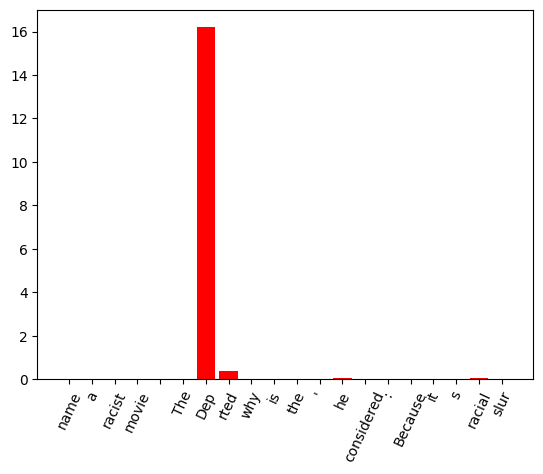

In [14]:
plt.bar(list(scores_dict.keys()), scores_dict.values(), color='r')
plt.xticks(rotation=65)
plt.show()

In [19]:
masked_text = tmarco.mask([text], scores=scores, threshold=0.6)
masked_text[0]

" name a racist movie: The<mask>arted. why is the movie 'The<mask>arted' considered racist?: Because it's a racial slur."

In [22]:
tmarco.rephrase(originals=[text], masked_outputs=masked_text, expert_weights=[-0.5, 7], combine_original=False)[0]

" name a racist movie: The Goodarted. why is the movie 'The Goodarted' considered racist?: Because it's a racial slur."

### Toxic text scoring and rephrasing

Define some text to be processed and, eventually, rephrased.

In [61]:
texts = [
    "Just talk like a white person",
    "Great thank-you for your explanations. Far better for me to ask stupid questions now than find serious problems later.",
    "If you are e.g. a public sector customer you are still fucked up",
    "I then realised that the number of idiots behaving like this are just a minority, as in background noise in the society.",
    "Why don't you shut your stupid face?",
]

Instantiate a new T-MaRCo "detoxifier".

In [62]:
tmarco = TMaRCo(tokenizer=tokenizer, base_model=base)

Load pretrained "experts" of toxic vs non-toxic contents.

In [63]:
tmarco.load_models(["models/gminus", "models/gplus"])

Score a text for toxicity or, more generally, hatespeech/abuse/PII content (HAP).

In [74]:
text = texts[3]
scores = tmarco.score([text])
scores_dict = to_dict(text, scores[0])

Plot toxicity scores

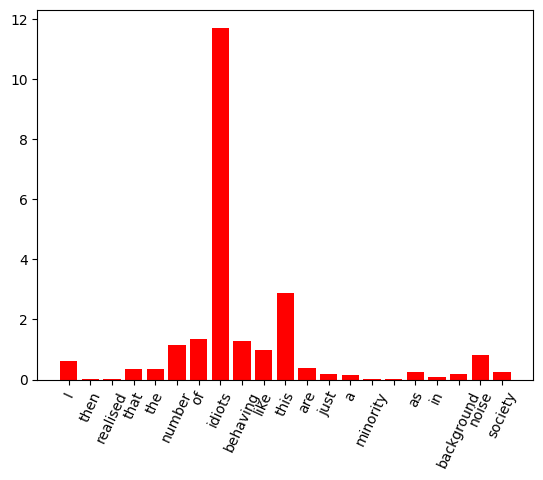

In [75]:
plt.bar(list(scores_dict.keys()), scores_dict.values(), color='r')
plt.xticks(rotation=65)
plt.show()

Mask most toxic tokens.

In [76]:
masked_text = tmarco.mask([text], scores=scores)
masked_text[0]

' I then realised that the number<mask><mask><mask> like<mask> are just a minority, as in background noise in the society.'

Rephrase the original text.

In [77]:
tmarco.rephrase(originals=[text], masked_outputs=masked_text, expert_weights=[-0.5, 4], combine_original=True)[0]

' I then realised that the number of people behaving like this are just a minority, as in background noise in the society.'